# Data Preprocessing för House Price Prediction

Vi ska genomföra följande steg:
1. Ladda och inspektera data
2. Hantera saknade värden
3. Feature engineering och transformationer
4. Skalning av data

In [2]:
# Import required libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Ladda data
df_train = pd.read_csv('home-data-for-ml-course/train.csv')
df_test = pd.read_csv('home-data-for-ml-course/test.csv')

print('Träningsdata shape:', df_train.shape)
print('Testdata shape:', df_test.shape)

Träningsdata shape: (1460, 81)
Testdata shape: (1459, 80)


In [3]:
# Visa information om datatyperna och saknade värden
print("TRÄNINGSDATA INFORMATION:")
print("\nKolumner och datatyper:")
print(df_train.dtypes)

print("\nSaknade värden i procent:")
missing_train = (df_train.isnull().sum() / len(df_train)) * 100
print(missing_train)

print("\n\nTESTDATA INFORMATION:")
print("\nKolumner och datatyper:")
print(df_test.dtypes)

print("\nSaknade värden i procent:")
missing_test = (df_test.isnull().sum() / len(df_test)) * 100
print(missing_test)

TRÄNINGSDATA INFORMATION:

Kolumner och datatyper:
Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

Saknade värden i procent:
Id                0.000000
MSSubClass        0.000000
MSZoning          0.000000
LotFrontage      17.739726
LotArea           0.000000
                   ...    
MoSold            0.000000
YrSold            0.000000
SaleType          0.000000
SaleCondition     0.000000
SalePrice         0.000000
Length: 81, dtype: float64


TESTDATA INFORMATION:

Kolumner och datatyper:
Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MiscVal            int64
MoSold             int64
YrSold             int64
SaleType          objec

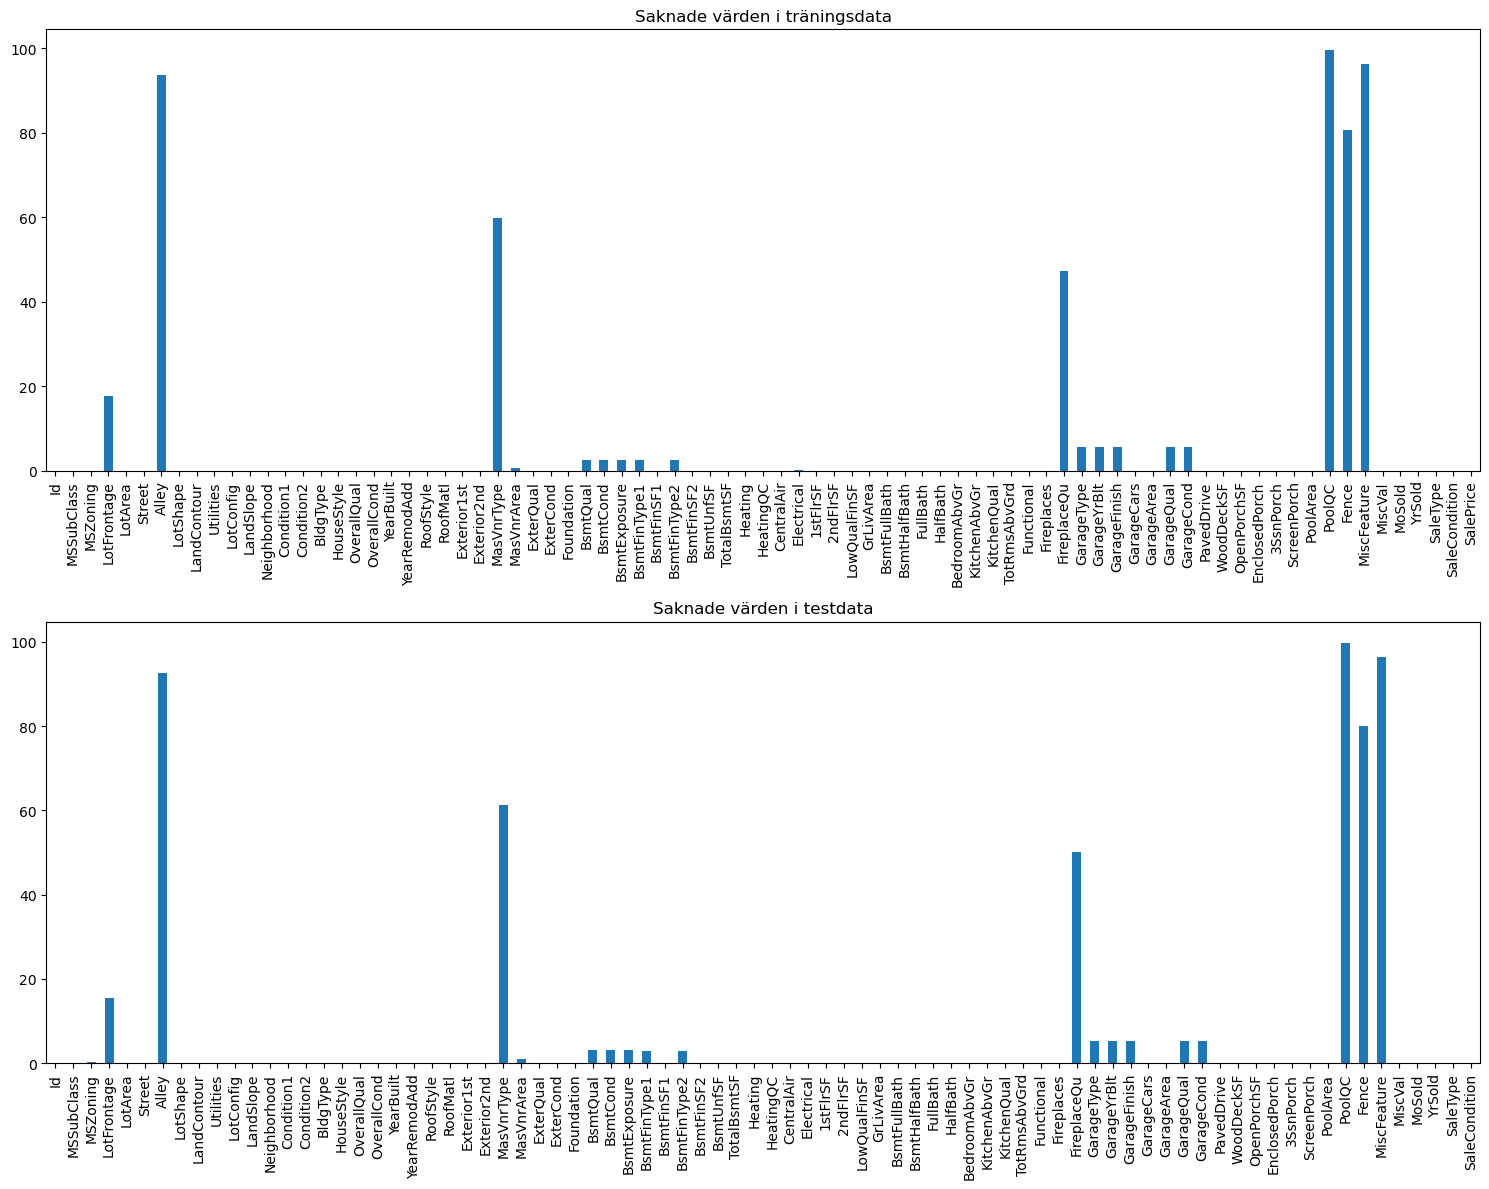

In [4]:
# Visualisering av saknade värden
plt.figure(figsize=(15, 12))

plt.subplot(2, 1, 1)
plt.title('Saknade värden i träningsdata')
missing_train.plot(kind='bar')
plt.xticks(rotation=90)

plt.subplot(2, 1, 2)
plt.title('Saknade värden i testdata')
missing_test.plot(kind='bar')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

# Datarengöring och Feature Selection

Vi ska nu:
1. Ta bort kolumner med för många saknade värden (>40%)
2. Behålla kategoriska variabler med få saknade värden (<5%)
3. Behålla viktiga numeriska variabler
4. Ta bort ID-kolumnen

In [6]:
# Funktion för att rengöra dataset enligt reglerna
def clean_dataset(df):
    # Ta bort Id-kolumnen
    if 'Id' in df.columns:
        df = df.drop('Id', axis=1)
    
    # Ta bort kolumner med mer än 40% saknade värden
    missing_percentages = df.isnull().sum() / len(df) * 100
    columns_to_drop = missing_percentages[missing_percentages > 40].index
    df = df.drop(columns_to_drop, axis=1)
    
    # Separera numeriska och kategoriska kolumner
    numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
    categorical_columns = df.select_dtypes(include=['object']).columns
    
    # Behåll endast kategoriska kolumner med mindre än 5% saknade värden
    categorical_missing = df[categorical_columns].isnull().sum() / len(df) * 100
    categorical_to_keep = categorical_missing[categorical_missing < 5].index
    
    # Kombinera kolumner att behålla
    columns_to_keep = list(numeric_columns) + list(categorical_to_keep)
    
    # Viktiga kolumner som vi alltid vill behålla
    important_columns = ['GrLivArea', 'OverallQual', 'GarageArea', 'TotalBsmtSF', 
                        'YearBuilt', 'LotArea']
    
    for col in important_columns:
        if col in df.columns and col not in columns_to_keep:
            columns_to_keep.append(col)
    
    return df[columns_to_keep]

# Applicera rengöring på både tränings- och testdata
df_train_cleaned = clean_dataset(df_train.copy())
df_test_cleaned = clean_dataset(df_test.copy())

print("Träningsdata shape före rengöring:", df_train.shape)
print("Träningsdata shape efter rengöring:", df_train_cleaned.shape)
print("\nTestdata shape före rengöring:", df_test.shape)
print("Testdata shape efter rengöring:", df_test_cleaned.shape)

print("\nKvarvarande kolumner:")
print(df_train_cleaned.columns.tolist())

Träningsdata shape före rengöring: (1460, 81)
Träningsdata shape efter rengöring: (1460, 70)

Testdata shape före rengöring: (1459, 80)
Testdata shape efter rengöring: (1459, 69)

Kvarvarande kolumner:
['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice', 'MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtEx

# Feature Engineering och Transformationer

Vi ska nu:
1. Skapa log-transformerade versioner av viktiga numeriska variabler
2. Hantera kategoriska variabler med one-hot encoding
3. Skala numeriska variabler

In [7]:
# Log-transformering av utvalda variabler
columns_to_transform = ['SalePrice', 'GrLivArea', 'LotArea']

# Skapa nya log-transformerade kolumner
for col in columns_to_transform:
    if col in df_train_cleaned.columns:
        df_train_cleaned[f'{col}_Log'] = np.log1p(df_train_cleaned[col])
    if col in df_test_cleaned.columns:
        df_test_cleaned[f'{col}_Log'] = np.log1p(df_test_cleaned[col])

# Visa exempel på original och transformerade värden
print("Exempel på original och transformerade värden (första 5 rader):")
cols_to_show = columns_to_transform + [f'{col}_Log' for col in columns_to_transform if col in df_train_cleaned.columns]
display(df_train_cleaned[cols_to_show].head())

Exempel på original och transformerade värden (första 5 rader):


,SalePrice,GrLivArea,LotArea,SalePrice_Log,GrLivArea_Log,LotArea_Log
0,208500,1710,8450,12.247699,7.444833,9.042040
1,181500,1262,9600,12.109016,7.141245,9.169623
2,223500,1786,11250,12.317171,7.488294,9.328212
3,140000,1717,9550,11.849405,7.448916,9.164401
4,250000,2198,14260,12.429220,7.695758,9.565284


In [8]:
# One-hot encoding av kategoriska variabler
def encode_categorical_variables(train_df, test_df):
    # Identifiera kategoriska kolumner
    categorical_columns = train_df.select_dtypes(include=['object']).columns
    
    # Skapa one-hot encoding för träningsdata
    train_encoded = pd.get_dummies(train_df, columns=categorical_columns)
    
    # Skapa one-hot encoding för testdata, se till att vi får samma kolumner som i träningsdata
    test_encoded = pd.get_dummies(test_df, columns=categorical_columns)
    
    # Säkerställ att test har samma kolumner som träning
    for col in train_encoded.columns:
        if col not in test_encoded.columns:
            test_encoded[col] = 0
    
    # Ordna kolumnerna så de matchar
    test_encoded = test_encoded[train_encoded.columns]
    
    return train_encoded, test_encoded

# Applicera encoding
df_train_encoded, df_test_encoded = encode_categorical_variables(df_train_cleaned, df_test_cleaned)

print("INFORMATION OM TRANSFORMATIONEN:")
print(f"Ursprunglig träningsdata shape: {df_train_cleaned.shape}")
print(f"Efter one-hot encoding shape: {df_train_encoded.shape}")
print(f"\nAntal nya kolumner skapade: {df_train_encoded.shape[1] - df_train_cleaned.shape[1]}")
print("\nExempel på nya dummy-variabler (första 5):")
new_cols = set(df_train_encoded.columns) - set(df_train_cleaned.columns)
print(list(new_cols)[:5])

INFORMATION OM TRANSFORMATIONEN:
Ursprunglig träningsdata shape: (1460, 73)
Efter one-hot encoding shape: (1460, 251)

Antal nya kolumner skapade: 178

Exempel på nya dummy-variabler (första 5):
['SaleCondition_Normal', 'BsmtFinType2_Unf', 'CentralAir_Y', 'BsmtQual_Fa', 'HouseStyle_1.5Fin']


In [10]:
from sklearn.preprocessing import StandardScaler

# Skalning av numeriska variabler
def scale_numeric_variables(train_df, test_df):
    # Identifiera numeriska kolumner (exkludera tidigare skapade log-transformerade kolumner)
    numeric_columns = train_df.select_dtypes(include=['int64', 'float64']).columns
    numeric_columns = [col for col in numeric_columns if not col.endswith('_Log')]
    
    # Initiera scaler
    scaler = StandardScaler()
    
    # Skapa kopior av dataframes för skalade värden
    train_scaled = train_df.copy()
    test_scaled = test_df.copy()
    
    # Anpassa scaler på träningsdata och transformera både träning och test
    train_scaled[numeric_columns] = scaler.fit_transform(train_df[numeric_columns])
    test_scaled[numeric_columns] = scaler.transform(test_df[numeric_columns])
    
    return train_scaled, test_scaled, numeric_columns

# Applicera skalning
df_train_scaled, df_test_scaled, scaled_columns = scale_numeric_variables(df_train_encoded, df_test_encoded)

print("INFORMATION OM SKALNINGEN:")
print(f"Antal skalade variabler: {len(scaled_columns)}")
print("\nExempel på original vs skalade värden (första 5 rader):")
example_cols = scaled_columns[:2]  # Visa bara första två variablerna för tydlighet
display(df_train_scaled[example_cols].head())

# Visa statistik för att verifiera skalningen
print("\nStatistik för skalade variabler (ska ha medelvärde ≈ 0 och std ≈ 1):")
scaled_stats = df_train_scaled[scaled_columns].describe().round(3)
display(scaled_stats)

# Spara de bearbetade datasetten
df_train_scaled.to_csv('processed_train.csv', index=False)
df_test_scaled.to_csv('processed_test.csv', index=False)
print("\nBearbetad data har sparats till 'processed_train.csv' och 'processed_test.csv'")

INFORMATION OM SKALNINGEN:
Antal skalade variabler: 37

Exempel på original vs skalade värden (första 5 rader):


,MSSubClass,LotFrontage
0,0.073375,-0.208034
1,-0.872563,0.409895
2,0.073375,-0.084449
3,0.309859,-0.414011
4,0.073375,0.574676



Statistik för skalade variabler (ska ha medelvärde ≈ 0 och std ≈ 1):


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000,1201.000,1460.000,1460.000,1460.000,1460.000,1460.000,1452.000,1460.000,1460.000,...,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000
mean,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,...,0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
min,-0.873,-2.021,-0.924,-3.688,-4.113,-3.288,-1.689,-0.573,-0.973,-0.289,...,-0.752,-0.704,-0.359,-0.116,-0.270,-0.069,-0.088,-1.969,-1.368,-1.839
25%,-0.873,-0.455,-0.297,-0.795,-0.517,-0.572,-0.866,-0.573,-0.973,-0.289,...,-0.752,-0.704,-0.359,-0.116,-0.270,-0.069,-0.088,-0.489,-0.614,-0.642
50%,-0.163,-0.043,-0.104,-0.072,-0.517,0.057,0.443,-0.573,-0.132,-0.289,...,-0.752,-0.327,-0.359,-0.116,-0.270,-0.069,-0.088,-0.119,0.139,-0.226
75%,0.310,0.410,0.109,0.651,0.382,0.952,0.927,0.344,0.589,-0.289,...,0.589,0.322,-0.359,-0.116,-0.270,-0.069,-0.088,0.621,0.892,0.417
max,3.148,10.008,20.518,2.821,3.079,1.283,1.218,8.267,11.406,8.852,...,6.088,7.554,8.675,17.217,8.341,18.306,31.165,2.101,1.645,7.229



Bearbetad data har sparats till 'processed_train.csv' och 'processed_test.csv'


# Linjär Regression och Visualisering

Vi ska:
1. Träna en linjär regressionsmodell på vårt förbehandlade data
2. Göra prediktioner
3. Utvärdera modellen med RMSE och R²
4. Visualisera:
   - Faktiska vs. predikterade värden
   - Residualplot
   - De viktigaste koefficienterna

RMSE: 0.1255
R²: 0.9156


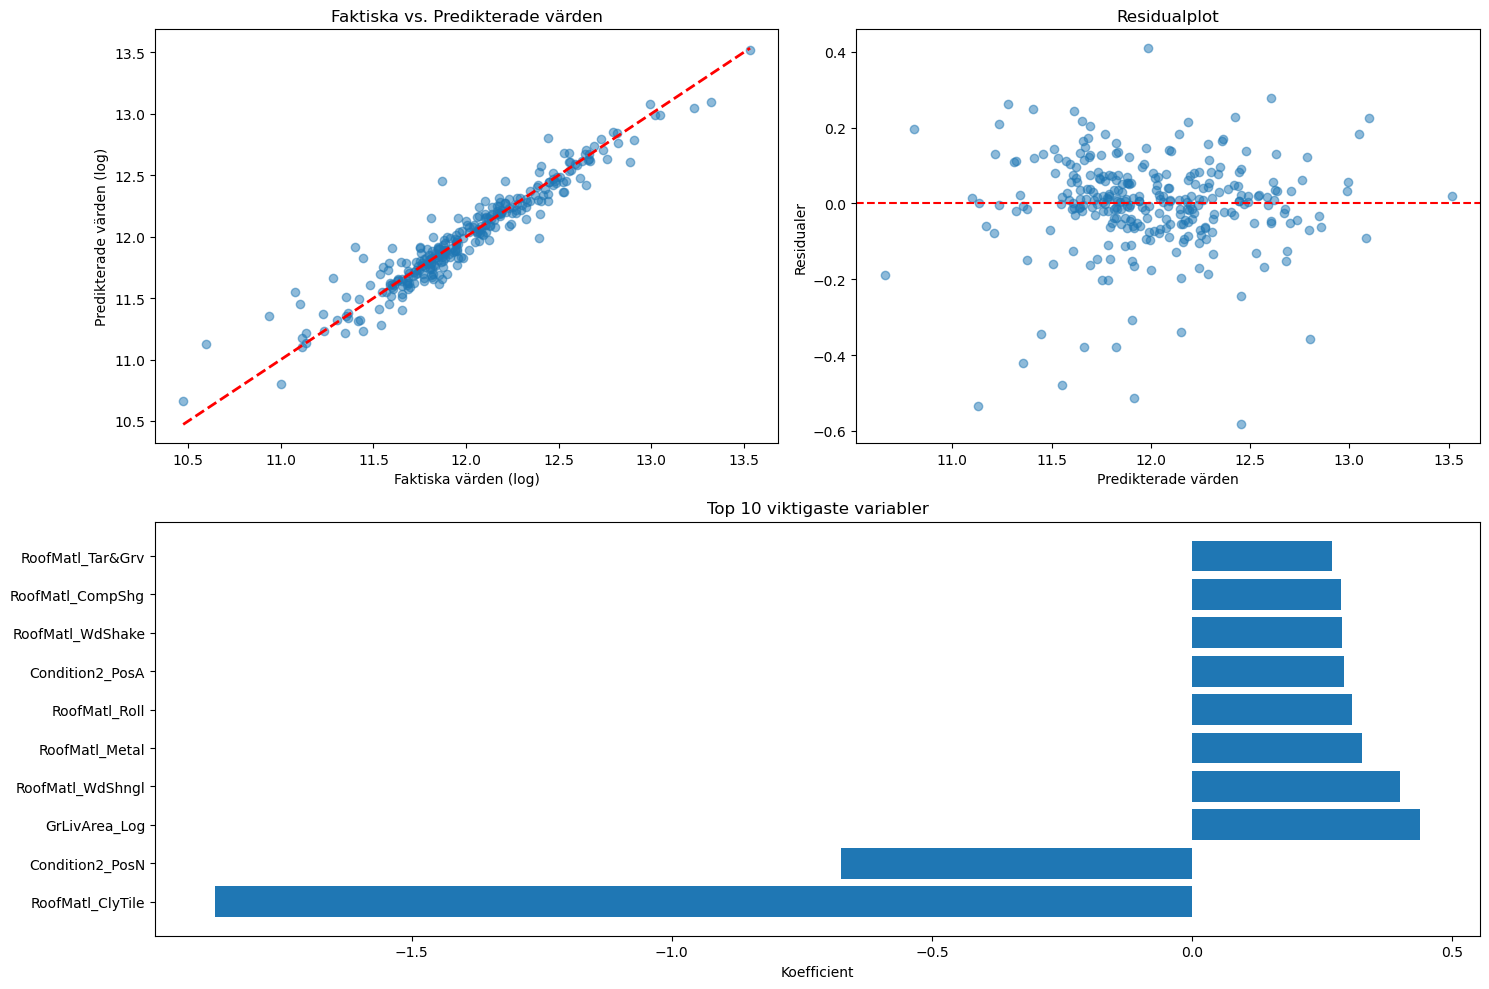


Top 10 viktigaste variabler:


,Variabel,Koefficient
124,RoofMatl_ClyTile,-1.877825
101,Condition2_PosN,-0.675556
36,GrLivArea_Log,0.437499
131,RoofMatl_WdShngl,0.399887
127,RoofMatl_Metal,0.326090
128,RoofMatl_Roll,0.308128
100,Condition2_PosA,0.292191
130,RoofMatl_WdShake,0.287280
125,RoofMatl_CompShg,0.286662
129,RoofMatl_Tar&Grv,0.269777


In [12]:
from sklearn.impute import SimpleImputer

# Förbereder data för modellering
X = df_train_scaled.drop(['SalePrice', 'SalePrice_Log'], axis=1)
y = df_train_scaled['SalePrice_Log']  # Använder log-transformerat pris

# Hantera saknade värden i X
imputer = SimpleImputer(strategy='mean')  # Fyller NaN med medelvärdet
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Dela upp data i träning och validering
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Träna linjär regressionsmodell
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Gör prediktioner
y_pred = lr_model.predict(X_val)

# Beräkna metrics
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print(f'RMSE: {rmse:.4f}')
print(f'R²: {r2:.4f}')

# Skapa visualiseringar
plt.figure(figsize=(15, 10))

# 1. Actual vs Predicted plot
plt.subplot(2, 2, 1)
plt.scatter(y_val, y_pred, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Faktiska värden (log)')
plt.ylabel('Predikterade värden (log)')
plt.title('Faktiska vs. Predikterade värden')

# 2. Residual plot
residuals = y_val - y_pred
plt.subplot(2, 2, 2)
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predikterade värden')
plt.ylabel('Residualer')
plt.title('Residualplot')

# 3. Koefficienter för de viktigaste variablerna
coef_df = pd.DataFrame({
    'Variabel': X.columns,
    'Koefficient': lr_model.coef_
}).sort_values('Koefficient', key=abs, ascending=False)

plt.subplot(2, 1, 2)
top_n = 10
plt.barh(coef_df['Variabel'][:top_n], coef_df['Koefficient'][:top_n])
plt.title(f'Top {top_n} viktigaste variabler')
plt.xlabel('Koefficient')

plt.tight_layout()
plt.show()

# Visa de 10 viktigaste variablerna och deras koefficienter
print("\nTop 10 viktigaste variabler:")
display(coef_df.head(10))

# KNN Regression med K-värdesoptimering

Vi ska:
1. Importera nödvändiga bibliotek och förbereda data
2. Testa olika k-värden (1-19)
3. Utvärdera modellerna med RMSE och R²
4. Visualisera:
   - Hur RMSE och R² förändras med olika k-värden
   - Jämförelse mellan faktiska och predikterade värden
   - Residualanalys för bästa modellen

In [14]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Förbereder data för modellering
X = df_train_scaled.drop(['SalePrice', 'SalePrice_Log'], axis=1)
y = df_train_scaled['SalePrice_Log']

# Hantera saknade värden
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Dela upp data i träning och validering
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Lista med k-värden att testa
k_values = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
rmse_values = []
r2_values = []

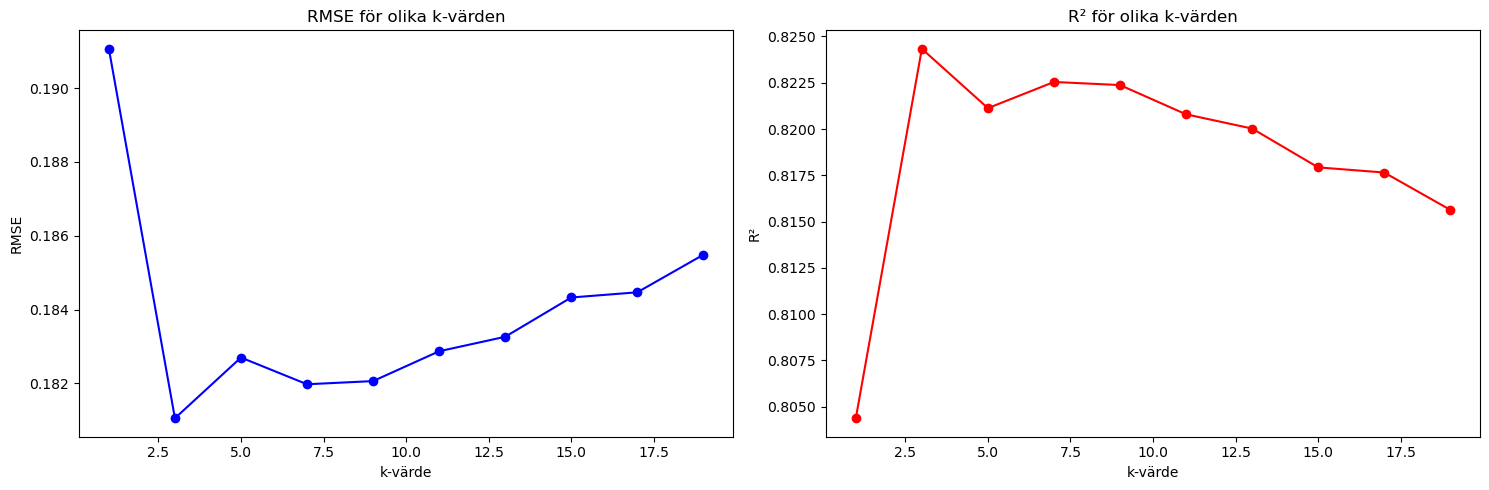

In [15]:
# Testa olika k-värden
for k in k_values:
    # Skapa och träna KNN-modell
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    # Gör prediktioner
    y_pred = knn.predict(X_val)
    
    # Beräkna metrics
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)
    
    # Spara resultaten
    rmse_values.append(rmse)
    r2_values.append(r2)

# Visualisera resultaten
plt.figure(figsize=(15, 5))

# RMSE plot
plt.subplot(1, 2, 1)
plt.plot(k_values, rmse_values, 'bo-')
plt.xlabel('k-värde')
plt.ylabel('RMSE')
plt.title('RMSE för olika k-värden')

# R² plot
plt.subplot(1, 2, 2)
plt.plot(k_values, r2_values, 'ro-')
plt.xlabel('k-värde')
plt.ylabel('R²')
plt.title('R² för olika k-värden')

plt.tight_layout()
plt.show()

Bästa k-värde: 3
Bästa RMSE: 0.1811
Bästa R²: 0.8243


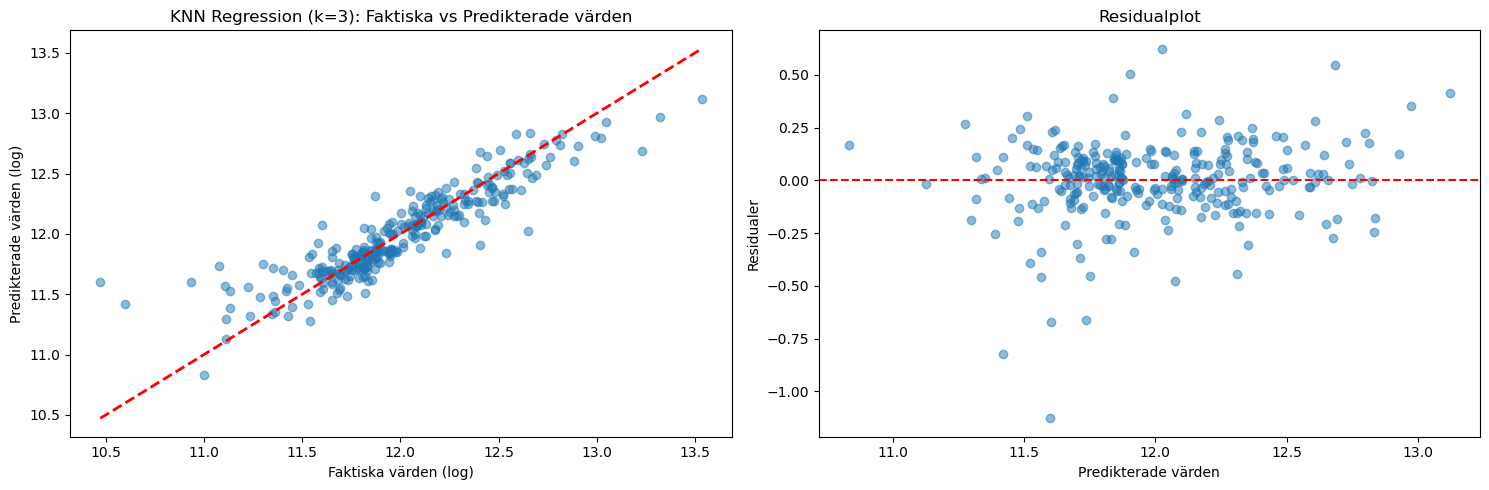


Residualstatistik:
Medelvärde av residualer: 0.0027
Standardavvikelse av residualer: 0.1813


In [16]:
# Hitta bästa k-värdet
best_k_index = np.argmin(rmse_values)
best_k = k_values[best_k_index]

print(f'Bästa k-värde: {best_k}')
print(f'Bästa RMSE: {rmse_values[best_k_index]:.4f}')
print(f'Bästa R²: {r2_values[best_k_index]:.4f}')

# Träna final modell med bästa k-värdet
final_knn = KNeighborsRegressor(n_neighbors=best_k)
final_knn.fit(X_train, y_train)

# Visualisera prediktioner vs faktiska värden
plt.figure(figsize=(15, 5))

# Actual vs Predicted plot
plt.subplot(1, 2, 1)
y_pred_best = final_knn.predict(X_val)
plt.scatter(y_val, y_pred_best, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Faktiska värden (log)')
plt.ylabel('Predikterade värden (log)')
plt.title(f'KNN Regression (k={best_k}): Faktiska vs Predikterade värden')

# Residual plot
plt.subplot(1, 2, 2)
residuals = y_val - y_pred_best
plt.scatter(y_pred_best, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predikterade värden')
plt.ylabel('Residualer')
plt.title('Residualplot')

plt.tight_layout()
plt.show()

# Visa statistik för residualerna
print("\nResidualstatistik:")
print(f"Medelvärde av residualer: {residuals.mean():.4f}")
print(f"Standardavvikelse av residualer: {residuals.std():.4f}")

# KNN med PCA (Principal Component Analysis)

Vi ska:
1. Använda PCA för dimensionsreduktion
2. Undersöka förklarad varians för olika antal komponenter
3. Träna KNN-modeller med PCA-transformerad data
4. Visualisera:
   - Förklarad varians vs antal komponenter
   - Projektion av data på de första PCA-komponenterna
   - Jämförelse av modellprestanda med och utan PCA

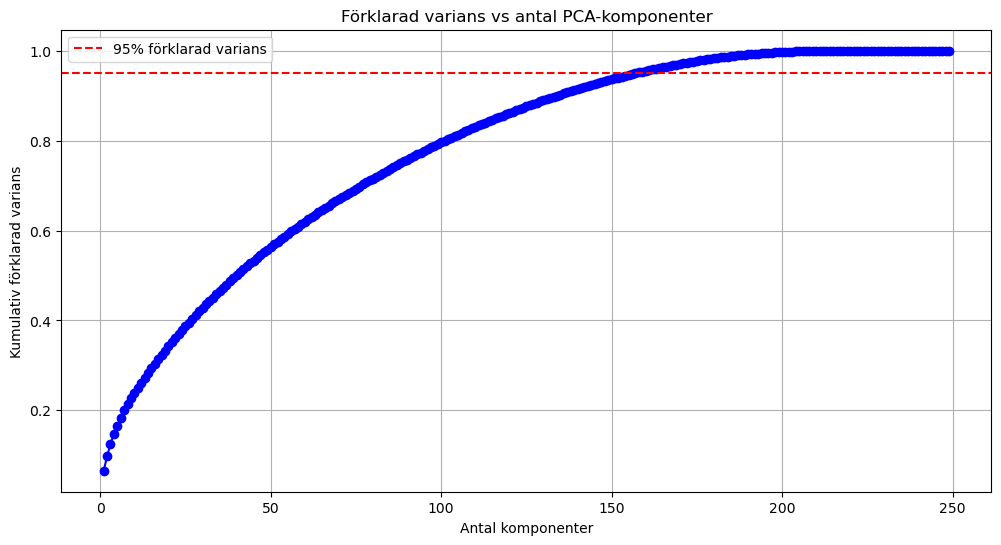

Antal komponenter som behövs för 95% förklarad varians: 158


In [18]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Förbereda data
X = df_train_scaled.drop(['SalePrice', 'SalePrice_Log'], axis=1)
y = df_train_scaled['SalePrice_Log']

from sklearn.impute import SimpleImputer

# Hantera saknade värden i X
imputer = SimpleImputer(strategy='mean')  # Fyller NaN med medelvärdet
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Skala data för PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Utför PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Beräkna kumulativ förklarad varians
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plotta förklarad varians
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% förklarad varians')
plt.xlabel('Antal komponenter')
plt.ylabel('Kumulativ förklarad varians')
plt.title('Förklarad varians vs antal PCA-komponenter')
plt.legend()
plt.grid(True)
plt.show()

# Hitta antal komponenter för 95% förklarad varians
n_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f'Antal komponenter som behövs för 95% förklarad varians: {n_components}')

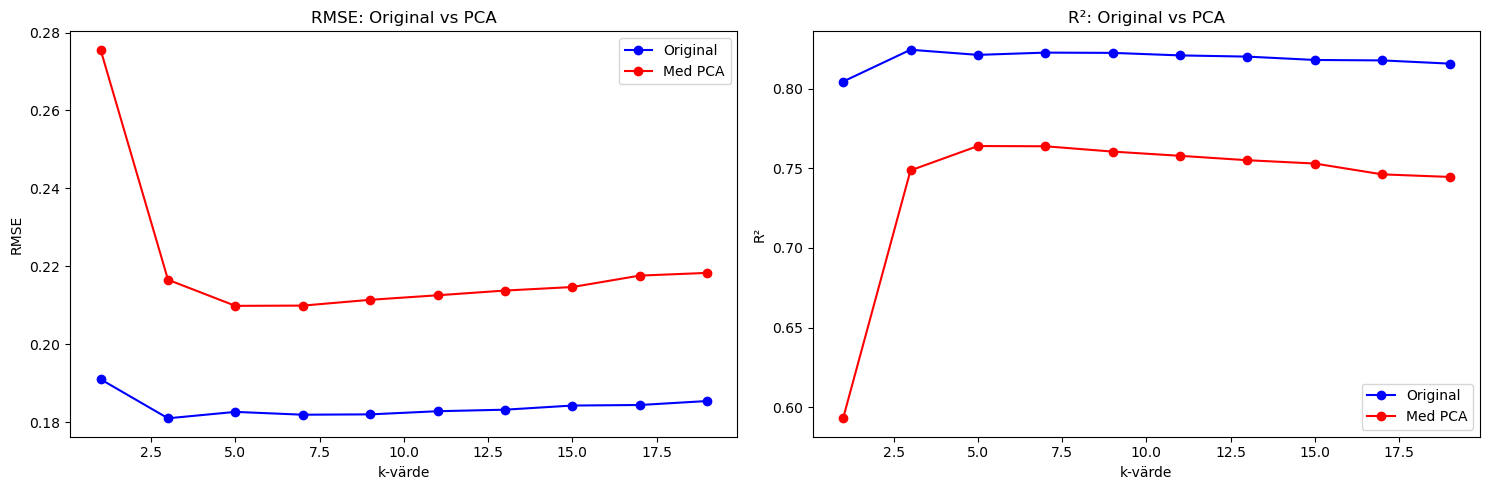

In [19]:
# Skapa PCA med optimalt antal komponenter
pca_optimal = PCA(n_components=n_components)
X_pca_optimal = pca_optimal.fit_transform(X_scaled)

# Dela upp data i träning och validering
X_train_pca, X_val_pca, y_train, y_val = train_test_split(X_pca_optimal, y, test_size=0.2, random_state=42)

# Träna KNN med PCA-transformerad data
k_values = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
rmse_values_pca = []
r2_values_pca = []

for k in k_values:
    knn_pca = KNeighborsRegressor(n_neighbors=k)
    knn_pca.fit(X_train_pca, y_train)
    y_pred_pca = knn_pca.predict(X_val_pca)
    
    rmse = np.sqrt(mean_squared_error(y_val, y_pred_pca))
    r2 = r2_score(y_val, y_pred_pca)
    
    rmse_values_pca.append(rmse)
    r2_values_pca.append(r2)

# Visualisera resultat
plt.figure(figsize=(15, 5))

# RMSE jämförelse
plt.subplot(1, 2, 1)
plt.plot(k_values, rmse_values, 'bo-', label='Original')
plt.plot(k_values, rmse_values_pca, 'ro-', label='Med PCA')
plt.xlabel('k-värde')
plt.ylabel('RMSE')
plt.title('RMSE: Original vs PCA')
plt.legend()

# R² jämförelse
plt.subplot(1, 2, 2)
plt.plot(k_values, r2_values, 'bo-', label='Original')
plt.plot(k_values, r2_values_pca, 'ro-', label='Med PCA')
plt.xlabel('k-värde')
plt.ylabel('R²')
plt.title('R²: Original vs PCA')
plt.legend()

plt.tight_layout()
plt.show()

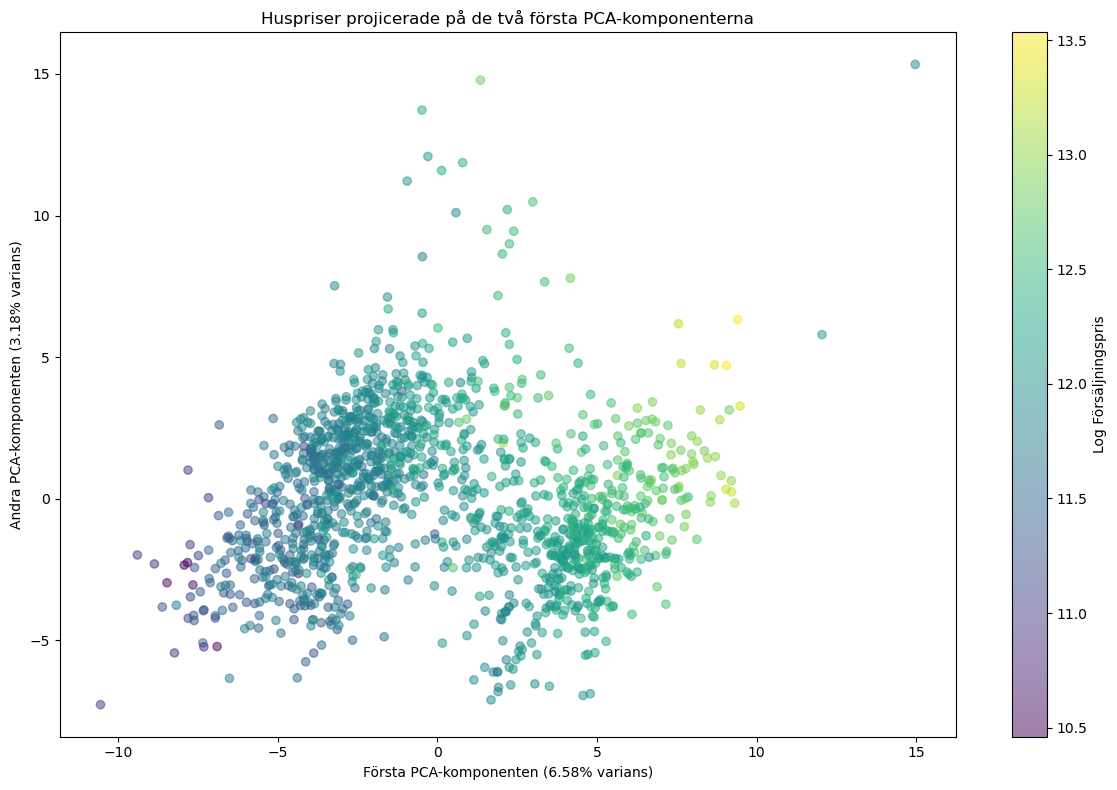

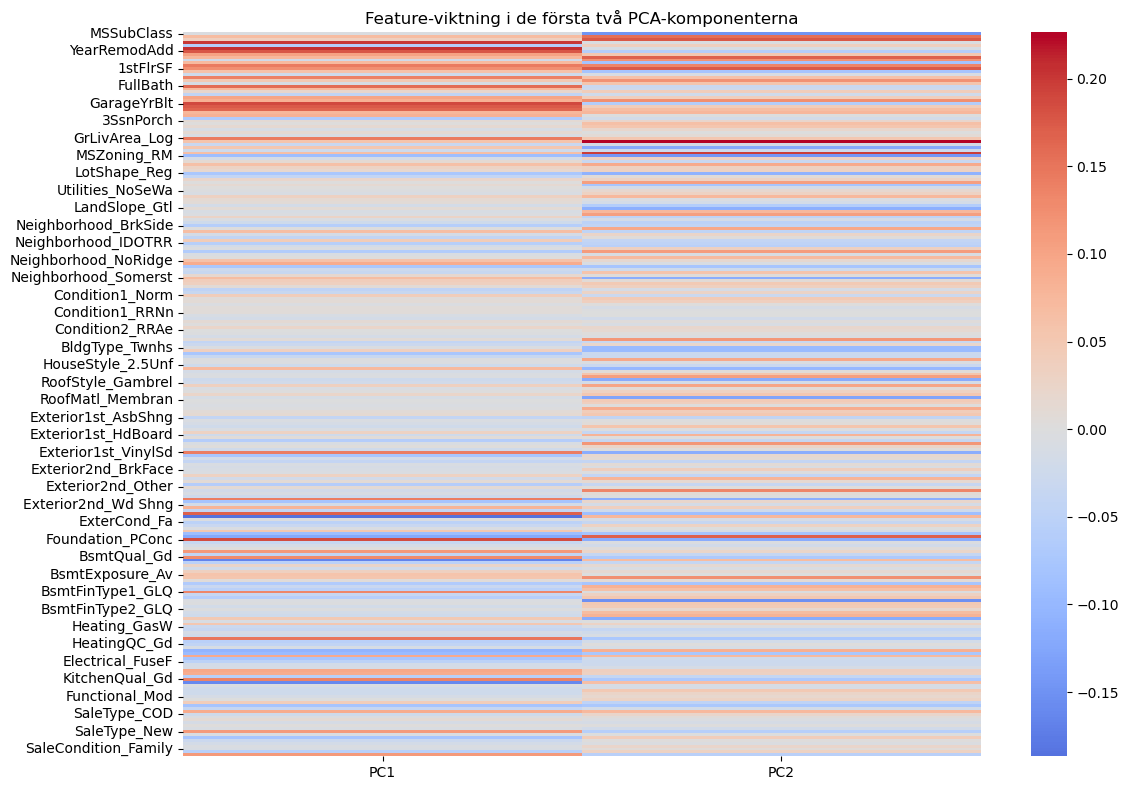

In [20]:
# Visualisera data i 2D med de två första PCA-komponenterna
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                     c=y, cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label='Log Försäljningspris')
plt.xlabel(f'Första PCA-komponenten ({pca_2d.explained_variance_ratio_[0]:.2%} varians)')
plt.ylabel(f'Andra PCA-komponenten ({pca_2d.explained_variance_ratio_[1]:.2%} varians)')
plt.title('Huspriser projicerade på de två första PCA-komponenterna')
plt.tight_layout()
plt.show()

# Visa viktigaste features för de första två komponenterna
feature_importance = pd.DataFrame(
    pca_2d.components_.T,
    columns=['PC1', 'PC2'],
    index=X.columns
)

plt.figure(figsize=(12, 8))
sns.heatmap(feature_importance, cmap='coolwarm', center=0)
plt.title('Feature-viktning i de första två PCA-komponenterna')
plt.tight_layout()
plt.show()

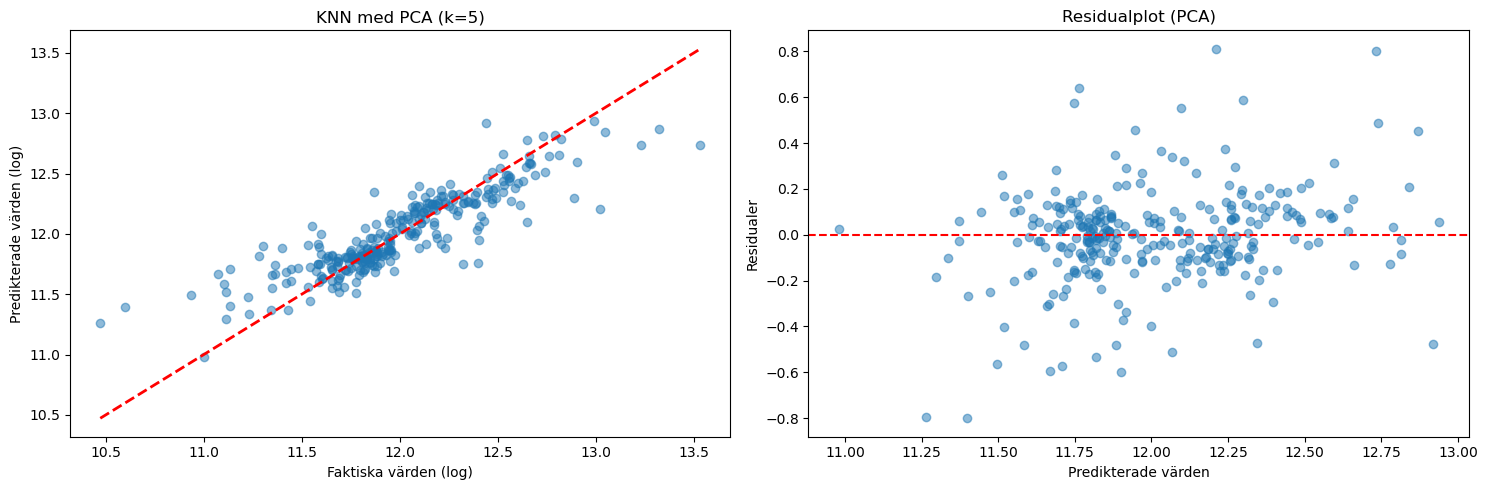


Jämförelse av modellprestanda:
Original KNN (k=3):
RMSE: 0.1811
R²: 0.8243

KNN med PCA (k=5):
RMSE: 0.2099
R²: 0.7639


In [21]:
# Träna final modell med bästa k-värdet och PCA
best_k_pca = k_values[np.argmin(rmse_values_pca)]
final_knn_pca = KNeighborsRegressor(n_neighbors=best_k_pca)
final_knn_pca.fit(X_train_pca, y_train)
y_pred_pca_best = final_knn_pca.predict(X_val_pca)

# Jämför prediktioner med och utan PCA
plt.figure(figsize=(15, 5))

# Original vs Predicted (PCA)
plt.subplot(1, 2, 1)
plt.scatter(y_val, y_pred_pca_best, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Faktiska värden (log)')
plt.ylabel('Predikterade värden (log)')
plt.title(f'KNN med PCA (k={best_k_pca})')

# Residualplot (PCA)
plt.subplot(1, 2, 2)
residuals_pca = y_val - y_pred_pca_best
plt.scatter(y_pred_pca_best, residuals_pca, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predikterade värden')
plt.ylabel('Residualer')
plt.title('Residualplot (PCA)')

plt.tight_layout()
plt.show()

# Visa jämförande statistik
print("\nJämförelse av modellprestanda:")
print(f"Original KNN (k={best_k}):")
print(f"RMSE: {min(rmse_values):.4f}")
print(f"R²: {max(r2_values):.4f}")
print(f"\nKNN med PCA (k={best_k_pca}):")
print(f"RMSE: {min(rmse_values_pca):.4f}")
print(f"R²: {max(r2_values_pca):.4f}")

# Model Performance Comparison

Vi ska jämföra prestandan för alla våra modeller genom att visualisera:
1. R² värden för varje modell i ett stapeldiagram
2. Visa exakta värden för enkel jämförelse
3. Sammanfatta modellernas styrkor och svagheter

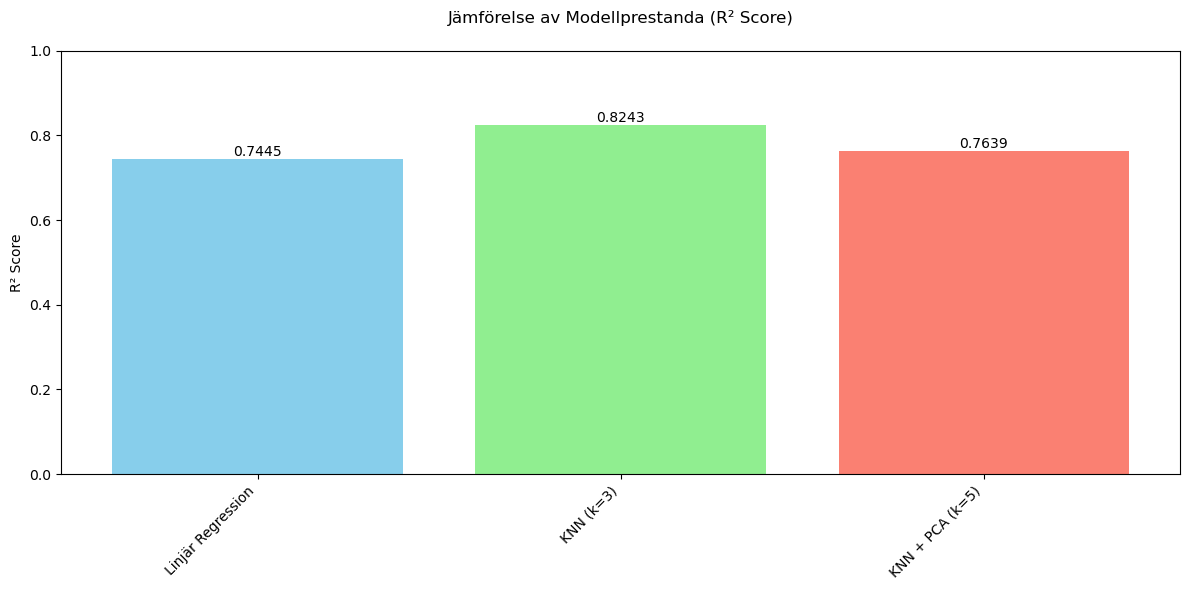


Detaljerad prestationsjämförelse:


,Modell,R² Score
0,Linjär Regression,0.7445
1,KNN (k=3),0.8243
2,KNN + PCA (k=5),0.7639



Sammanfattning av modellprestanda:
Bästa modell: KNN (k=3) med R² = 0.8243


In [22]:
# Samla R² scores för alla modeller
models_performance = {
    'Linjär Regression': r2,
    f'KNN (k={best_k})': max(r2_values),
    f'KNN + PCA (k={best_k_pca})': max(r2_values_pca)
}

# Skapa stapeldiagram
plt.figure(figsize=(12, 6))

# Skapa staplar med olika färger
bars = plt.bar(models_performance.keys(), models_performance.values(), 
        color=['skyblue', 'lightgreen', 'salmon'])

# Lägg till värden ovanför staplarna
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom')

plt.title('Jämförelse av Modellprestanda (R² Score)', pad=20)
plt.ylabel('R² Score')
plt.ylim(0, 1)  # Sätt y-axeln från 0 till 1

# Rotera x-labels för bättre läsbarhet
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Skriv ut exakta värden i en tabell
print("\nDetaljerad prestationsjämförelse:")
comparison_df = pd.DataFrame({
    'Modell': models_performance.keys(),
    'R² Score': models_performance.values()
}).round(4)
display(comparison_df)

# Skriv ut sammanfattande analys
print("\nSammanfattning av modellprestanda:")
best_model = max(models_performance.items(), key=lambda x: x[1])
print(f"Bästa modell: {best_model[0]} med R² = {best_model[1]:.4f}")